In [2]:
suppressWarnings(suppressMessages(library(tidyverse))) #ggplot and dplyr
suppressWarnings(suppressMessages(library(scales))) #scales for plots
suppressWarnings(suppressMessages(library(reshape2))) #melt
suppressWarnings(suppressMessages(require(gridExtra))) #Aggregate plots
suppressWarnings(suppressMessages(library(caret))) #evaluation metrics (such as confusion matrix)
suppressWarnings(suppressMessages(library(glmnet))) #ridge and lasso
suppressWarnings(suppressMessages(library(ROCR))) #Calculate and plot ROC curves and AUC
suppressWarnings(suppressMessages(library(here))) #To use with source and import custom made functions

#Import custom made functions
suppressWarnings(suppressMessages(source(here::here("Help_Functions.r"))))

#read the dataset
uci_heart = read_csv("heart.csv", col_types = c("nffnnffnfdffff"))

#remove wrong thal values
uci_heart = uci_heart[uci_heart$thal != 0, ]
uci_heart$thal = droplevels(uci_heart$thal, exclude = "0")
uci_heart$target = relevel(uci_heart$target, "0")
uci_heart$cp = relevel(uci_heart$cp, "1")

set.seed(1)
uci_heart = uci_heart[sample(nrow(uci_heart)), ] #shuffle data, randomize dataframe

# UCI Heart Disease Dataset - Feature Selection

The objective of this notebook is to explore different methods of feature selection and compare the results of each of the methods.

The methods used in this notebooks are:
* Ridge Regression
* Lasso Regression
* Normal Logistic Regression (for comparison purposes)

First of all, we start by dividing the dataset into a train and test set. **70%** for the train set and **30%** for the test set.

In [3]:
set.seed(1)
train_idx = sample(1:nrow(uci_heart), 0.7*nrow(uci_heart))

train = uci_heart[train_idx, ]
test = uci_heart[-train_idx, ]

x_train = model.matrix(target ~ ., data = train)[, -1]
y_train = train$target

x_test = model.matrix(target ~ ., data = test)[, -1]
y_test = test$target

# Ridge Regression
The ridge regression is a **shrinkage method** similar to the least squares method, that minimizes a slightly different quantity. [1]

The coefficients for the model variables in the ridge regression take values according to their significance, **lower values mean lower significance**. These value tend to zero, but **never reach zero**.

This method has a variable (**lambda $\lambda$**), which functions as a *tuning parameter* to minimize the cost function of this method, however **higher values of $\lambda$ cause a higher shrinkage penalty**.

[1] 0.06289682

[1] 0.3356614

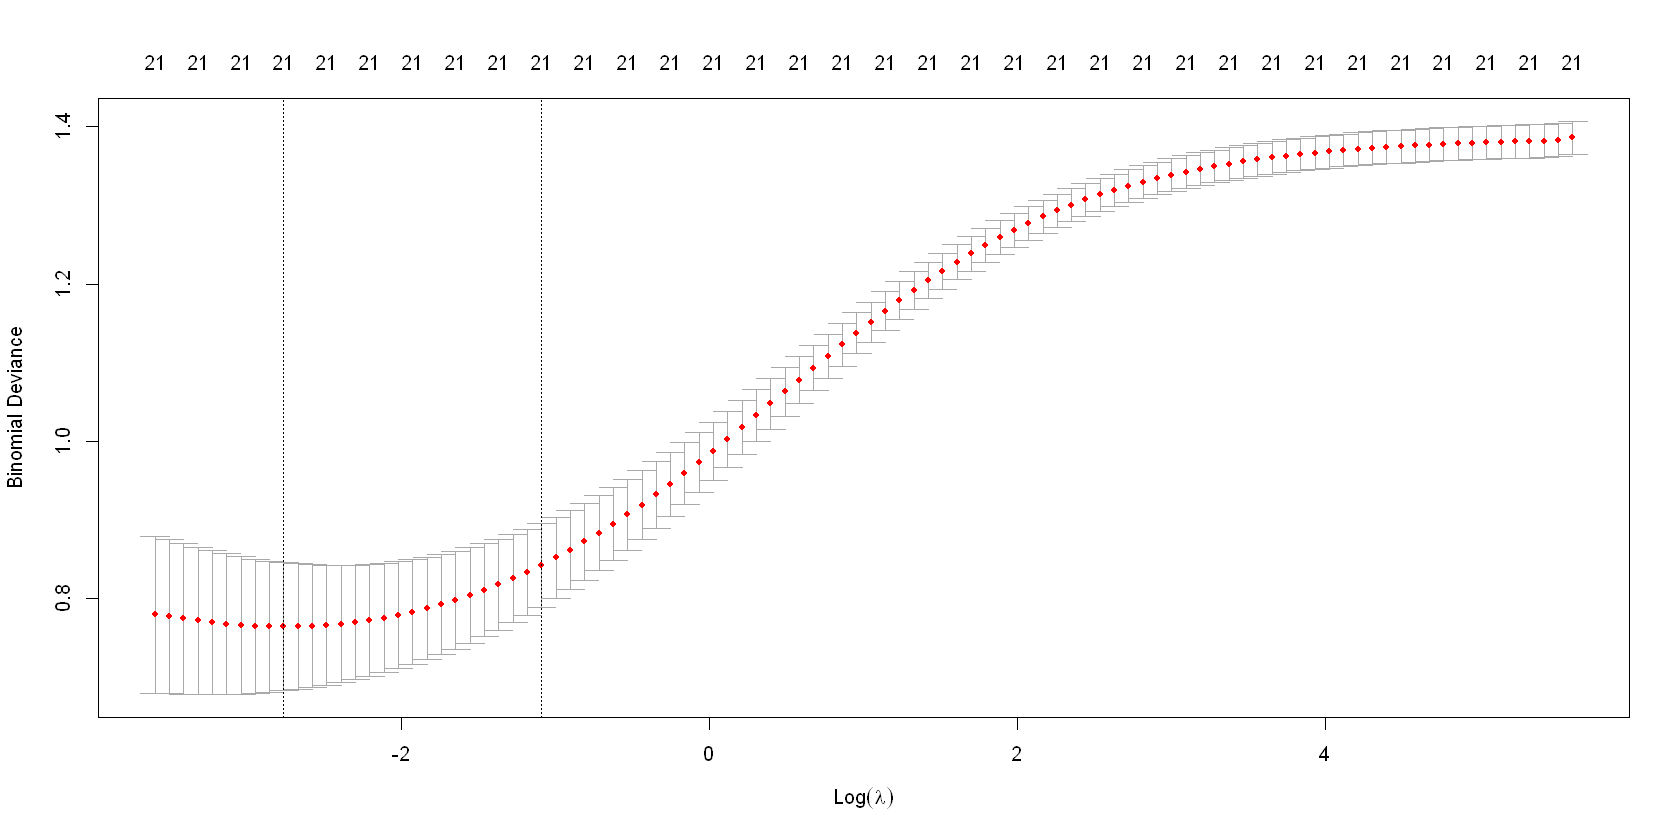

In [4]:
set.seed(1)
cv.ridge = cv.glmnet(x_train, y_train, alpha = 0, nfolds = 10, family = "binomial") #10 folds cross validation / binomial = classification / alpha 0 = ridge regression

options(repr.plot.width = 14, repr.plot.heigh = 7)
plot(cv.ridge)

cv.ridge$lambda.min
cv.ridge$lambda.1se

The plot shown above shows the values of $Log(\lambda)$ that influence the cross validation error of the ridge regression. In this case, **smaller values of $\lambda$ give smaller cross validation errors**.

After cross validating a ridge model using the *cv.glmnet* method, we can access the best $\lambda$ values for this data. The focus is on two different $\lambda$ values:
* lambda.min -> The best lambda value, i.e. the value that provides the model with the **smallest error**.
* lambda.1se -> The lambda value that provides the model with the **smallest number of predictors**, but still gives an acceptable cross validation error. [[2]](http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/)

Do keep in mind that for the ridge regression, the *lambda.1se* provides the **smallest coefficients**, but it does not remove any predictors. [[2]](http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/)

## Best model

The best model uses the value of *lambda.min*, we must keep in mind that the *glmnet* method performs the **standardization of the values implicitly**, therefore we do not need to worry about performing it explicitly.

In [5]:
ridge.min = glmnet(x_train, y_train, alpha = 0, family = 'binomial', lambda = cv.ridge$lambda.min)
coef(cv.ridge, cv.ridge$lambda.min)

22 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -0.4150208531
age          0.0125272227
sex0         0.7504649101
cp3          1.0451169004
cp2          0.5071781192
cp0         -0.7712363505
trestbps    -0.0106032279
chol         0.0003725434
fbs0        -0.0379758588
restecg1     0.5254763481
restecg2    -0.2907954904
thalach      0.0119331170
exang1      -0.4565875783
oldpeak     -0.2494487461
slope2       0.4979424701
slope1      -0.3435282476
ca2         -1.4146537234
ca1         -1.0984173234
ca3         -1.0481500980
ca4          0.5798856808
thal2        0.6446725022
thal3       -0.6501347313

## Smallest model

The smallest model uses the value of *lambda.1se* to produce the model with the smallest coefficients. Just like the best model, the standardization of the values is performed implicitly.

In [6]:
ridge.1se = glmnet(x_train, y_train, alpha = 0, family = 'binomial', lambda = cv.ridge$lambda.1se)
coef(cv.ridge, cv.ridge$lambda.1se)

22 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  3.523317e-02
age         -1.303675e-03
sex0         3.645527e-01
cp3          4.630687e-01
cp2          2.835059e-01
cp0         -4.840715e-01
trestbps    -4.592279e-03
chol        -4.623544e-05
fbs0         3.885594e-02
restecg1     2.528698e-01
restecg2    -1.496907e-01
thalach      7.678596e-03
exang1      -3.297072e-01
oldpeak     -1.580356e-01
slope2       2.980476e-01
slope1      -2.421181e-01
ca2         -5.506589e-01
ca1         -4.067581e-01
ca3         -4.625138e-01
ca4          2.264615e-01
thal2        4.629957e-01
thal3       -4.311001e-01

Since **model interpretation** might be important for some cases, specially when the model has a large ammount of variables, this approach may not be the best, since the coeffiecients tend to zero, but are never exactly zero (**unless $\lambda = \infty$**). Therefore, we study a different approach that provides a solution for a more interpretable model.

Looking at the coefficients of each model, it is possible to see that the smallest model has **smaller coefficient values** than the best model.

# Lasso Regression

Just like we mentioned before, the lasso regression is a similar approach to the ridge regression, but unlike the ridge this approach allows the coefficients to be **zero**, meaning that the model will be **smaller and easier to interpret**. Because of this property, it is said that the lasso yields **sparse models**, meaning models that contain only a subset of the total variables. [3]

In terms of MSE (Mean Squared Error) and prediction accuracy, both the lasso and the ridge models tend to yield similar results, however these results depend heavily on the **context of the problem**. In a problem where all the variables are more or less correlated to the response variable, we will see that the ridge will show an improvement in variance and MSE, however, if we can see that a lot of variables have low coeffficient values, then the lasso will yield a better MSE, with the advantage of performing feature selection and making the model more readable. [4]

[1] 0.02208428

[1] 0.06145082

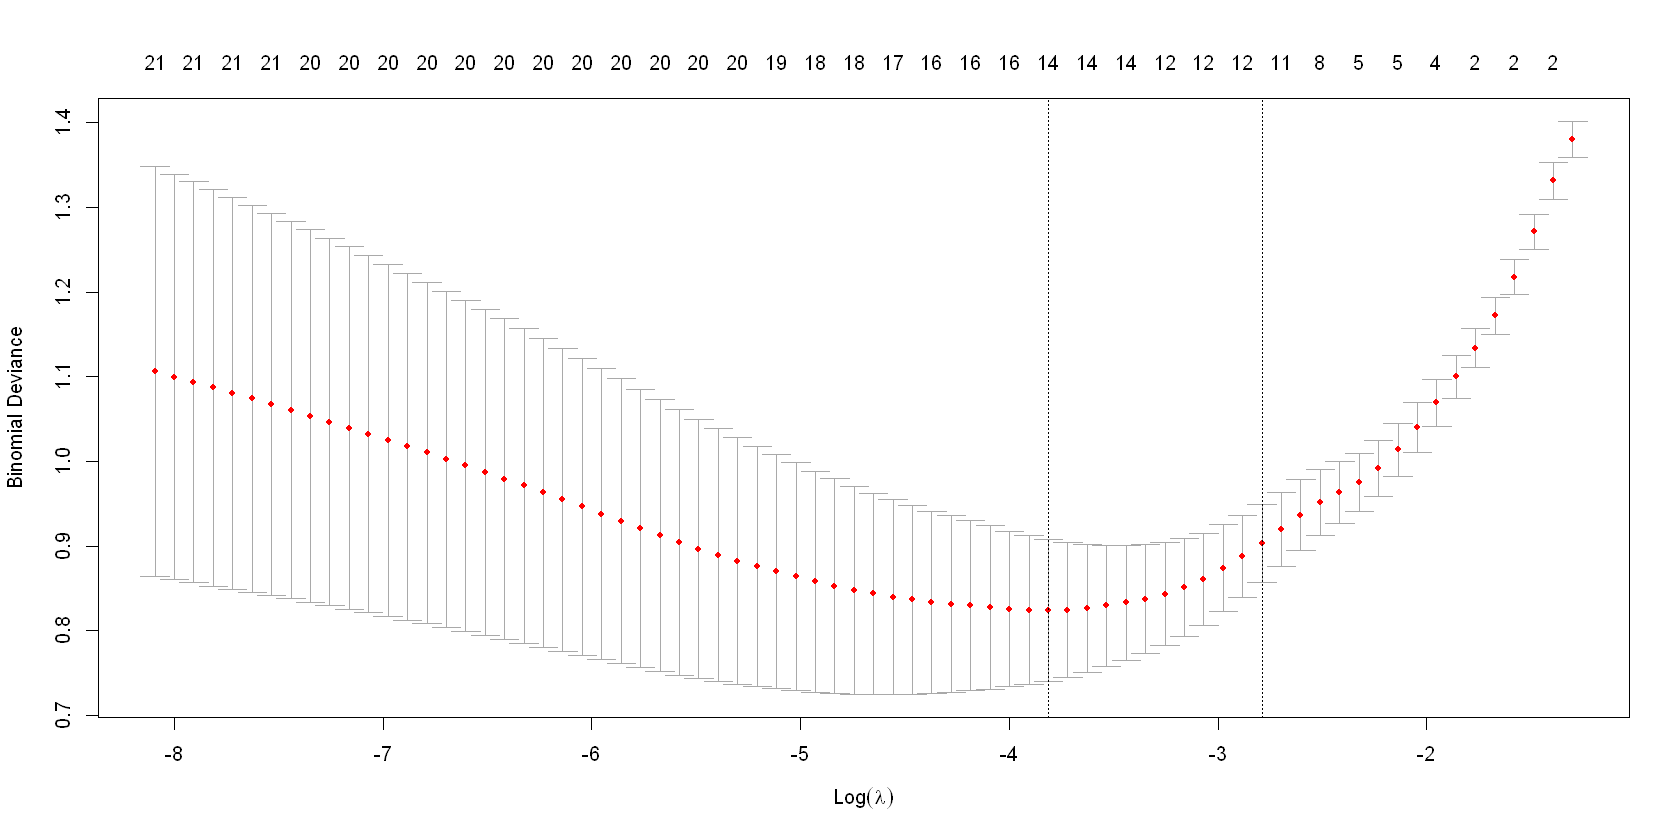

In [7]:
set.seed(1)
cv.lasso = cv.glmnet(x_train, y_train, alpha = 1, family = "binomial", nfolds = 10)
plot(cv.lasso)

cv.lasso$lambda.min
cv.lasso$lambda.1se

The plot shows us that the $\lambda$ values cannot be too low or too high in order to have a better cross validation error.

Just like in the ridge regression, this model has a *lambda.min* for the $\lambda$ value that yields the **best model**, with the lowest error and a *lambda.1se* which is very important for the lasso model, because it yields the **smallest model**, meaning it will have the most **coefficients equal to zero**.

## Best model

The model with the smallest error, made with the *lambda.min* value.

In [8]:
lasso.min = glmnet(x_train, y_train, alpha = 1, family = 'binomial', lambda = cv.lasso$lambda.min)
coef(cv.lasso, cv.lasso$lambda.min)

22 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept)  0.177317782
age          .          
sex0         0.723225189
cp3          0.317094657
cp2          .          
cp0         -1.313398401
trestbps    -0.004991646
chol         .          
fbs0         .          
restecg1     0.446607248
restecg2     .          
thalach      0.009153764
exang1      -0.306905256
oldpeak     -0.215042205
slope2       0.711899741
slope1       .          
ca2         -1.588244928
ca1         -1.233629589
ca3         -0.921575381
ca4          .          
thal2        0.677700243
thal3       -0.571253981

## Smallest model

The model that has most coefficients as zero, made with the *lambda.1se* value.

In [9]:
lasso.1se = glmnet(x_train, y_train, alpha = 1, family = 'binomial', lambda = cv.lasso$lambda.1se)
coef(cv.lasso, cv.lasso$lambda.1se)

22 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) -0.819269693
age          .          
sex0         0.160465783
cp3          .          
cp2          .          
cp0         -1.041471850
trestbps     .          
chol         .          
fbs0         .          
restecg1     0.102977818
restecg2     .          
thalach      0.008069094
exang1      -0.091251077
oldpeak     -0.173652615
slope2       0.281492324
slope1       .          
ca2         -0.411256921
ca1         -0.338166458
ca3         -0.053908574
ca4          .          
thal2        1.036976991
thal3       -0.111404011

The lasso approach can be very beneficial for this problem, since there are quite a few variables in the model and we can see that **9 coefficients are equal to zero**, meaning that the model can be heavily reduced.

The use of the *lambda.1se* seems to be beneficial as well, since it will **reduce the model even more** and make it even more interpretable.

# Logistic Regression

For the sake of comparison, we fit a normal logistic regression model to the complete model, in order to compare it with the lasso and ridge methods and check its results accuracy.

In [10]:
set.seed(1)
glm.fit = glm(target ~ ., data = train, family = "binomial")
summary(glm.fit)


Call:
glm(formula = target ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0334  -0.2195   0.1100   0.4229   3.0894  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.7820923  3.9773107  -0.699  0.48425    
age          0.0647597  0.0317787   2.038  0.04157 *  
sex0         1.8220327  0.7445244   2.447  0.01440 *  
cp3          2.5518988  1.2611539   2.023  0.04303 *  
cp2          1.1079616  0.8279902   1.338  0.18085    
cp0         -0.8669775  0.7699603  -1.126  0.26016    
trestbps    -0.0310204  0.0162006  -1.915  0.05552 .  
chol         0.0001806  0.0057161   0.032  0.97479    
fbs0        -0.5233615  0.7180120  -0.729  0.46606    
restecg1     0.8501566  0.5196519   1.636  0.10184    
restecg2    -0.7268949  3.0283141  -0.240  0.81030    
thalach      0.0283853  0.0175251   1.620  0.10530    
exang1      -0.6319526  0.5892285  -1.073  0.28349    
oldpeak     -0.1764264  0.3313926

# Conclusion and Comparison

One important aspect to take in consideration when comparing models is that the dataset only contains **301 rows** which is fairly low, making some of this results inconclusive.

The graph shown here compares a lot of metrics, however for the case of feature selection, we will focus more on the **recall, precision and overall accuracy** of the model.

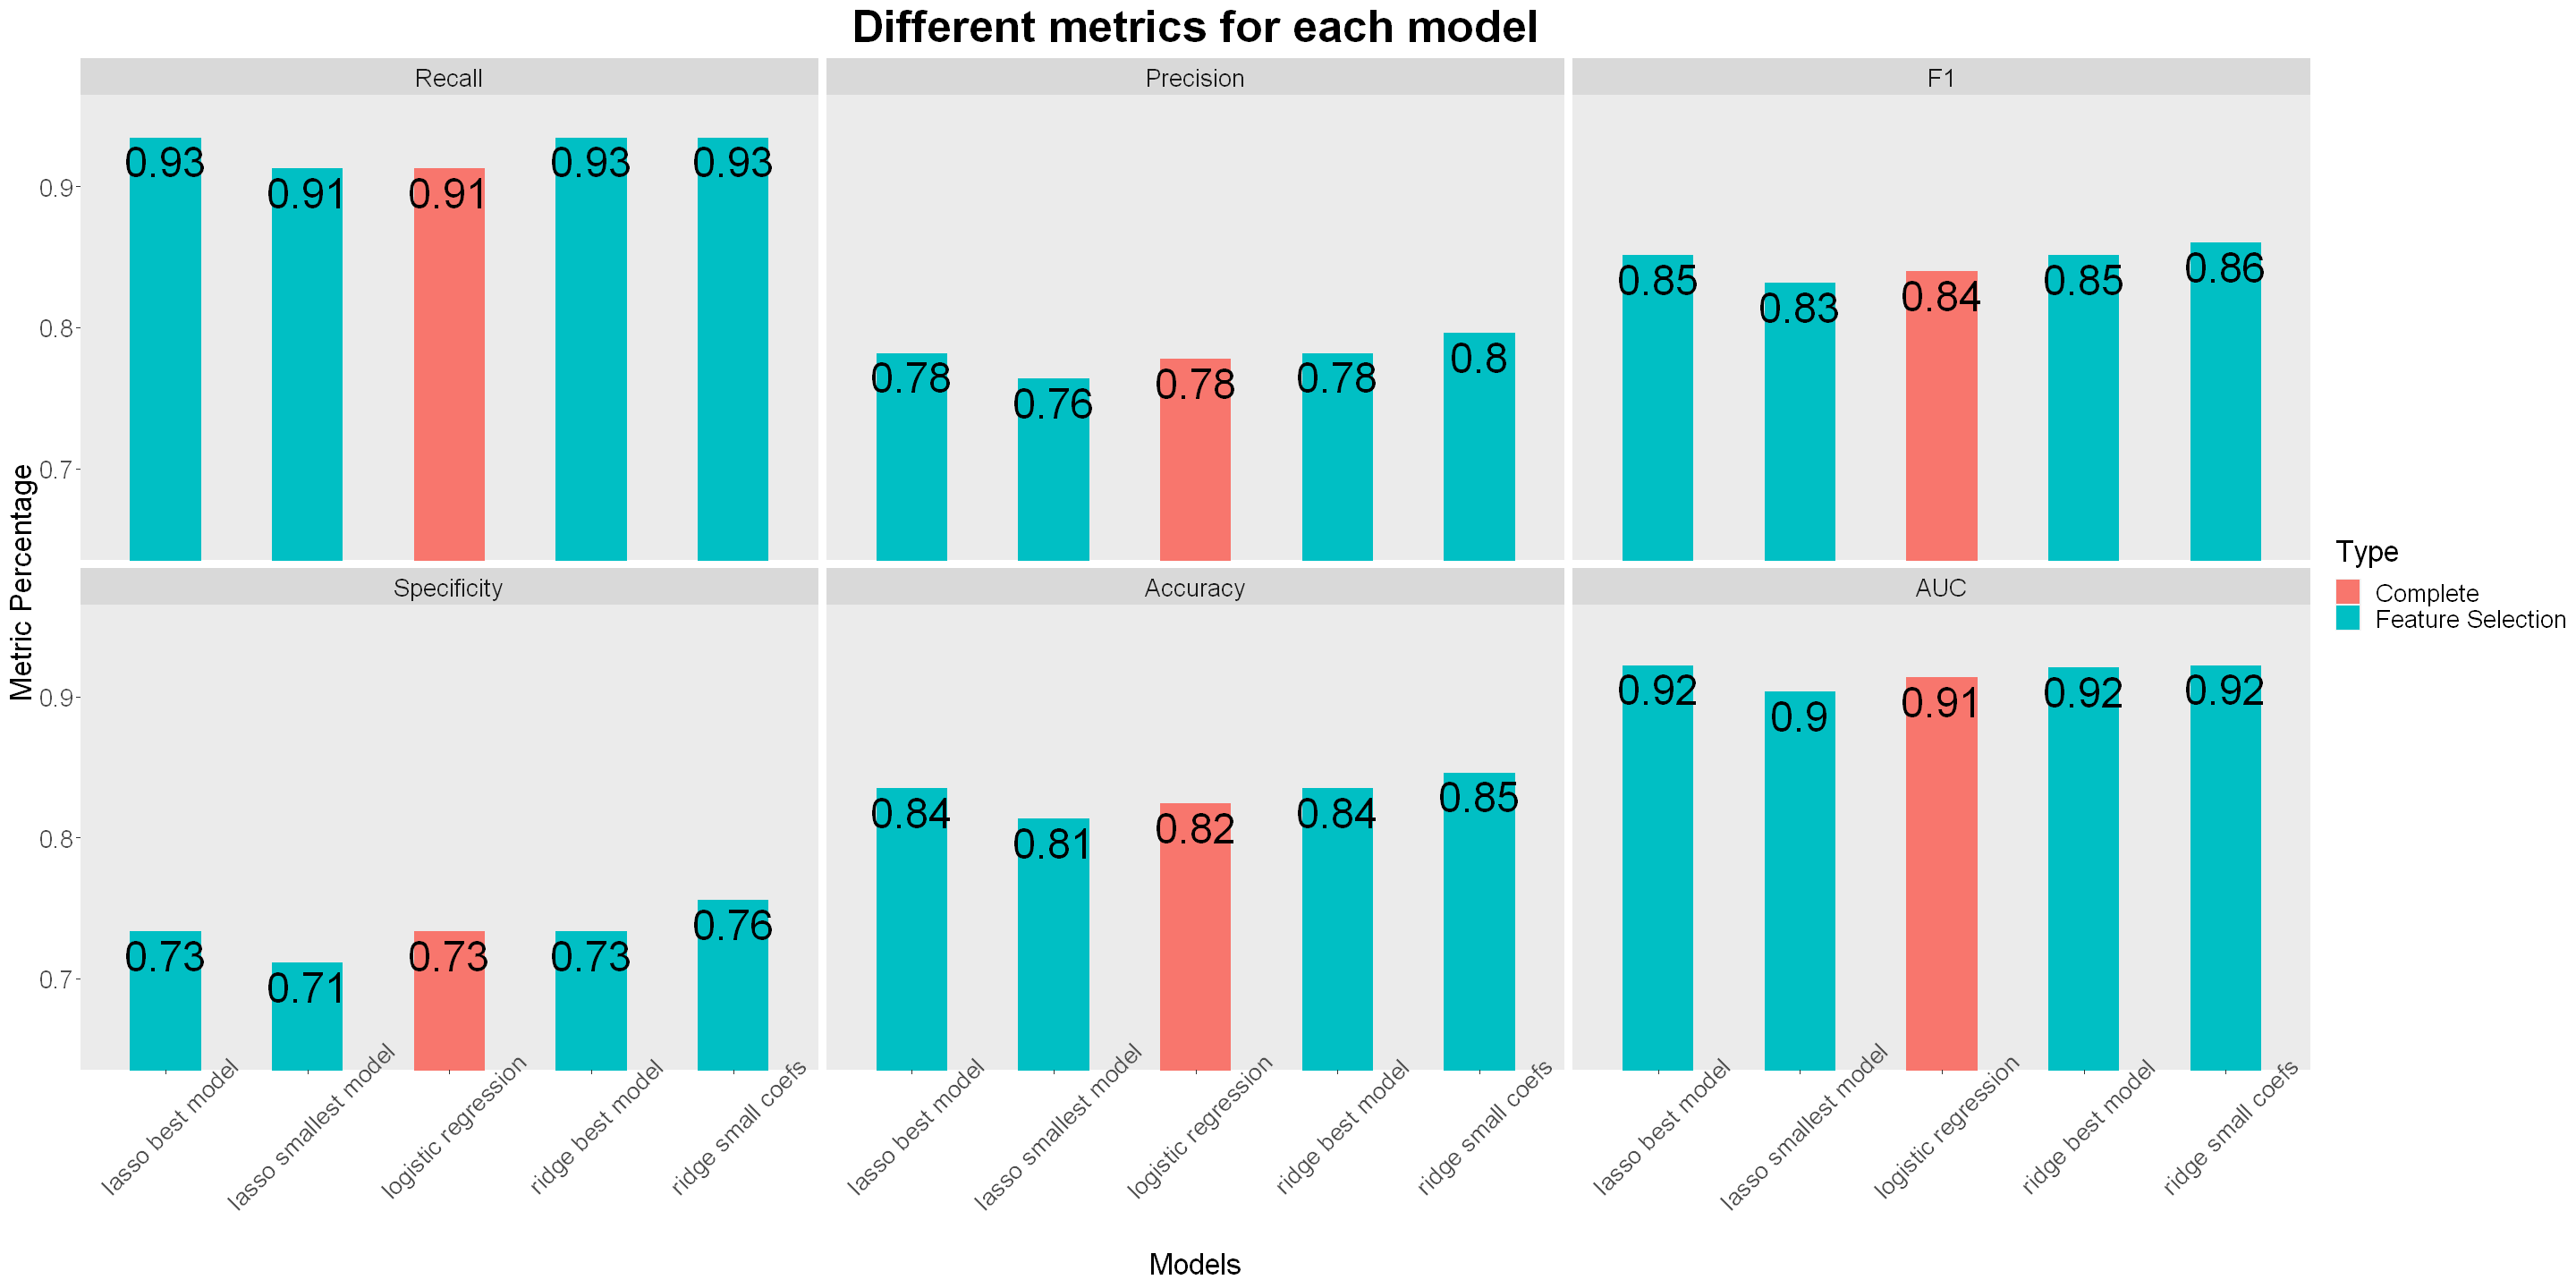

In [11]:
models.comp = list(glm.fit)
models.feat = list(ridge.min, ridge.1se, lasso.min, lasso.1se)

metrics = evaluate_models(models.comp, models.feat, feature.selection = TRUE, x.models = c("logistic regression", "ridge best model", "ridge small coefs", "lasso best model", "lasso smallest model"))

There is one important side note to make about the graph above, since the dataset is short on rows, the metric values do not have a high oscillations, which makes it difficult to compare the models. Despite this fact, it is still possible to observe a few small differences, so the conclusions made will be based on those differences.

Since this problem uses a **medical dataset**, the **recall** is a very important measure. When predicting diseases, it is more important to correctly predict the **positive cases** rather than the negative ones, since the consequences for misclassifying a patient who is not sick are **much less serious** than the consequences for misclassifying a patient who is actually sick.

Taking all of these observations into account, a few conclusions are made:
* In terms of **recall**, no model is clearly the best, but all of the them have a **fairly high recall**.
* Looking at the **precision**, the ridge regression method might have an advantage over the others, making it better for predicting **positive cases**.
* In general, the **ridge regression yields better results than the lasso**, it also has better results than the logistic regression, specially the **ridge with small coefficients**.
* When it comes to the **ridge**, the **lambda that gives the low coefficients** (small model) has better results than the supposed "best model", which means that the lambdas have some influence on the model.
* In the **lasso** models, having a **smaller model** makes it more interpretable, but it also **decreases its prediction accuracy**.

In conclusion, even though these results **favour the ridge regression**, we will still test the feature selection of the lasso for the classification models and further explore if the lasso does indeed **reduce the prediction accuracy** of the models.

### References
[1] - James, G., Witten, D., Hastie, T., Tibshirani, R. (2013, pg. 215). An Introduction to Statistical Learning with Applications in R (8th ed.). Midtown Manhattan, NY: Springer Publishing

[2] - Kassambara (2018). Penalized Logistic Regression Essentials in R: Ridge, Lasso and Elastic Net. http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/

[3] - James, G., Witten, D., Hastie, T., Tibshirani, R. (2013, pg. 219). An Introduction to Statistical Learning with Applications in R (8th ed.). Midtown Manhattan, NY: Springer Publishing

[4] - James, G., Witten, D., Hastie, T., Tibshirani, R. (2013, pg. 223/224). An Introduction to Statistical Learning with Applications in R (8th ed.). Midtown Manhattan, NY: Springer Publishing